In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import QuantileTransformer

In [2]:
df = pd.read_csv('/kaggle/input/insurance-claims-fraud-data/insurance_data.csv')
df.head()

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID
0,2020-06-01 00:00:00,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,Health,157.13,9000,...,A,Major Loss,Police,0,1,GA,Savannah,4,AGENT00413,VNDR00556
1,2020-06-01 00:00:00,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,Property,141.71,26000,...,A,Total Loss,Ambulance,1,0,AL,Montgomery,0,AGENT00769,VNDR00592
2,2020-06-01 00:00:00,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,Property,157.24,13000,...,A,Total Loss,Police,0,1,CO,Grand Junction,19,AGENT00883,VNDR00031
3,2020-06-01 00:00:00,TXN00000004,A00007572,PLC00009292,2016-11-29,2020-05-14,2020-05-19,Health,172.87,16000,...,A,Minor Loss,Ambulance,0,0,GA,Savannah,12,AGENT00278,VNDR00075
4,2020-06-01 00:00:00,TXN00000005,A00008173,PLC00000204,2011-12-26,2020-05-17,2020-05-22,Travel,88.53,3000,...,A,Major Loss,Police,0,1,TN,Nashville,18,AGENT00636,VNDR00472


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TXN_DATE_TIME             10000 non-null  object 
 1   TRANSACTION_ID            10000 non-null  object 
 2   CUSTOMER_ID               10000 non-null  object 
 3   POLICY_NUMBER             10000 non-null  object 
 4   POLICY_EFF_DT             10000 non-null  object 
 5   LOSS_DT                   10000 non-null  object 
 6   REPORT_DT                 10000 non-null  object 
 7   INSURANCE_TYPE            10000 non-null  object 
 8   PREMIUM_AMOUNT            10000 non-null  float64
 9   CLAIM_AMOUNT              10000 non-null  int64  
 10  CUSTOMER_NAME             10000 non-null  object 
 11  ADDRESS_LINE1             10000 non-null  object 
 12  ADDRESS_LINE2             1495 non-null   object 
 13  CITY                      9946 non-null   object 
 14  STATE  

In [4]:
df.describe(include='number')

,PREMIUM_AMOUNT,CLAIM_AMOUNT,POSTAL_CODE,AGE,TENURE,NO_OF_FAMILY_MEMBERS,ROUTING_NUMBER,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_HOUR_OF_THE_DAY
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,88.508595,16563.830000,48288.830500,44.466100,62.949800,4.488400,7.052882e+07,0.699100,0.692800,11.604000
std,48.315874,22037.489735,32467.389801,11.516827,32.890604,1.712588,3.451879e+07,0.458672,0.461356,6.877101
min,6.000000,100.000000,1001.000000,25.000000,6.000000,2.000000,1.000074e+07,0.000000,0.000000,0.000000
25%,62.015000,2000.000000,21061.000000,34.000000,34.000000,3.000000,4.071761e+07,0.000000,0.000000,6.000000
50%,88.835000,7000.000000,37206.000000,45.000000,64.000000,4.000000,7.036614e+07,1.000000,1.000000,12.000000
75%,121.902500,21000.000000,80004.000000,54.000000,92.000000,6.000000,1.000638e+08,1.000000,1.000000,18.000000
max,200.000000,100000.000000,99669.000000,64.000000,119.000000,7.000000,1.299981e+08,1.000000,1.000000,23.000000


In [5]:
age_skew = df['AGE'].skew()
age_skew

-0.013721780685095082

# Checking the distribution and Skewness of all numeric columns

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


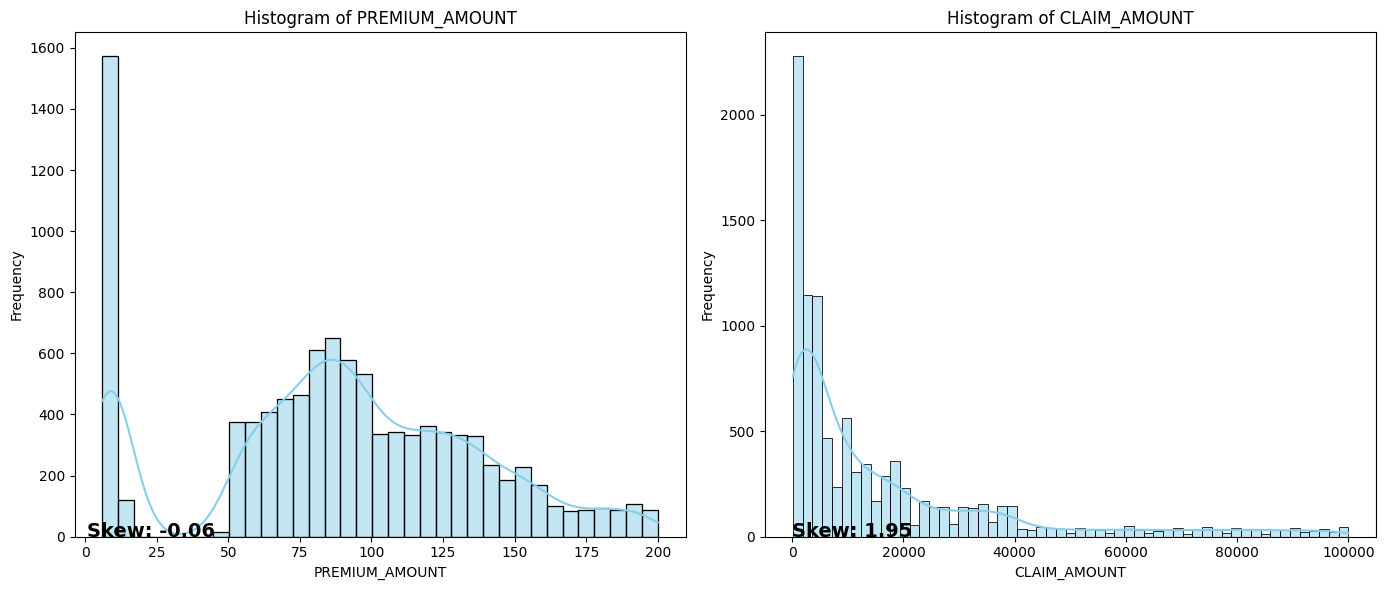

In [6]:
columns_1 = ['PREMIUM_AMOUNT', 'CLAIM_AMOUNT']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, ax in enumerate(axes.flat):
    column = columns_1[i]
    sns.histplot(df[column], kde=True, color='skyblue', ax=ax)
    ax.text(0.5, 0.5, f'Skew: {df[column].skew():.2f}', color='black', weight='bold', fontsize=14)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


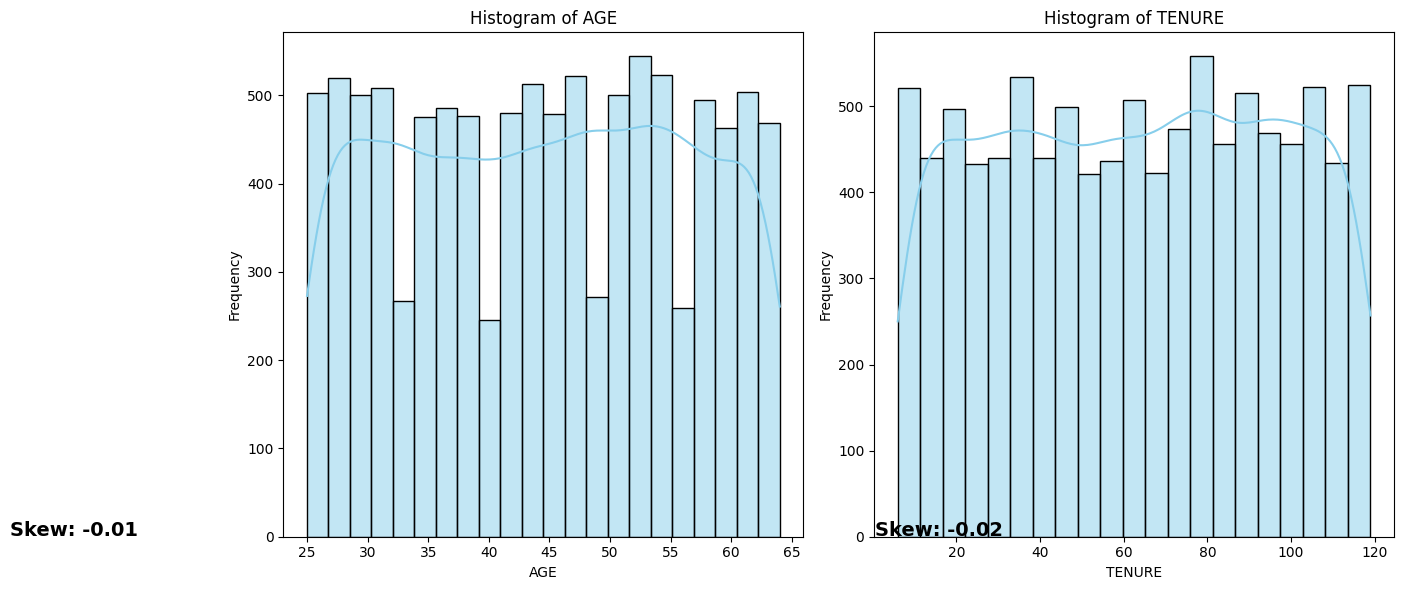

In [7]:
columns_2 = ['AGE', 'TENURE']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, ax in enumerate(axes.flat):
    column = columns_2[i]
    sns.histplot(df[column], kde=True, color='skyblue', ax=ax)
    ax.text(0.5, 0.5, f'Skew: {df[column].skew():.2f}', color='black', weight='bold', fontsize=14)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0.5, 'Skew: -0.01')

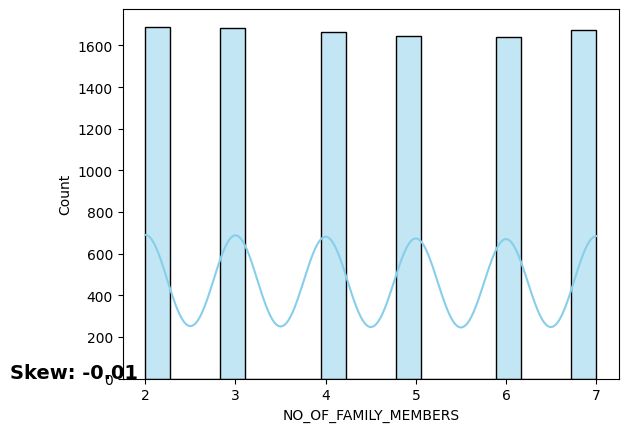

In [8]:
sns.histplot(df['NO_OF_FAMILY_MEMBERS'], kde=True, color='skyblue').text(0.5, 0.5, f'Skew: {age_skew:.2f}', color='black', weight='bold', fontsize=14)

# Premium Amount

In [9]:
df['PREMIUM_AMOUNT'].skew()

-0.06427549480759316

In [10]:
df['Squared_PREMIUM_AMOUNT'] = (df['PREMIUM_AMOUNT'])** 2
print(f"Skewness after Square Transformation: {df['Squared_PREMIUM_AMOUNT'].skew():.5f}")

Skewness after Square Transformation: 1.13304


In [11]:
df['Cubed_PREMIUM_AMOUNT'] = (df['PREMIUM_AMOUNT'])** 3
print(f"Skewness after Cube Transformation: {df['Cubed_PREMIUM_AMOUNT'].skew():.5f}")

Skewness after Cube Transformation: 1.94288


In [12]:
if (df['PREMIUM_AMOUNT'] > 0).all():
    df['BoxCox_PREMIUM_AMOUNT'], _ = boxcox(df['PREMIUM_AMOUNT'])
else:
    print("Not all SalePrice values are positive. Consider using Yeo-Johnson or handling negative values.")
print(f"Skewness after Box-Cox Transformation: {df['BoxCox_PREMIUM_AMOUNT'].skew():.5f}")

Skewness after Box-Cox Transformation: -0.29576


In [13]:
df['YeoJohnson_PREMIUM_AMOUNT'], _ = yeojohnson(df['PREMIUM_AMOUNT'])
print(f"Skewness after Yeo-Johnson Transformation: {df['YeoJohnson_PREMIUM_AMOUNT'].skew():.5f}")

Skewness after Yeo-Johnson Transformation: -0.28068


In [14]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df['Quantile_PREMIUM_AMOUNT'] = quantile_transformer.fit_transform(df['PREMIUM_AMOUNT'].values.reshape(-1, 1)).flatten()
print(f"Skewness after Quantile Transformation: {df['Quantile_PREMIUM_AMOUNT'].skew():.5f}")

Skewness after Quantile Transformation: -0.00030


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

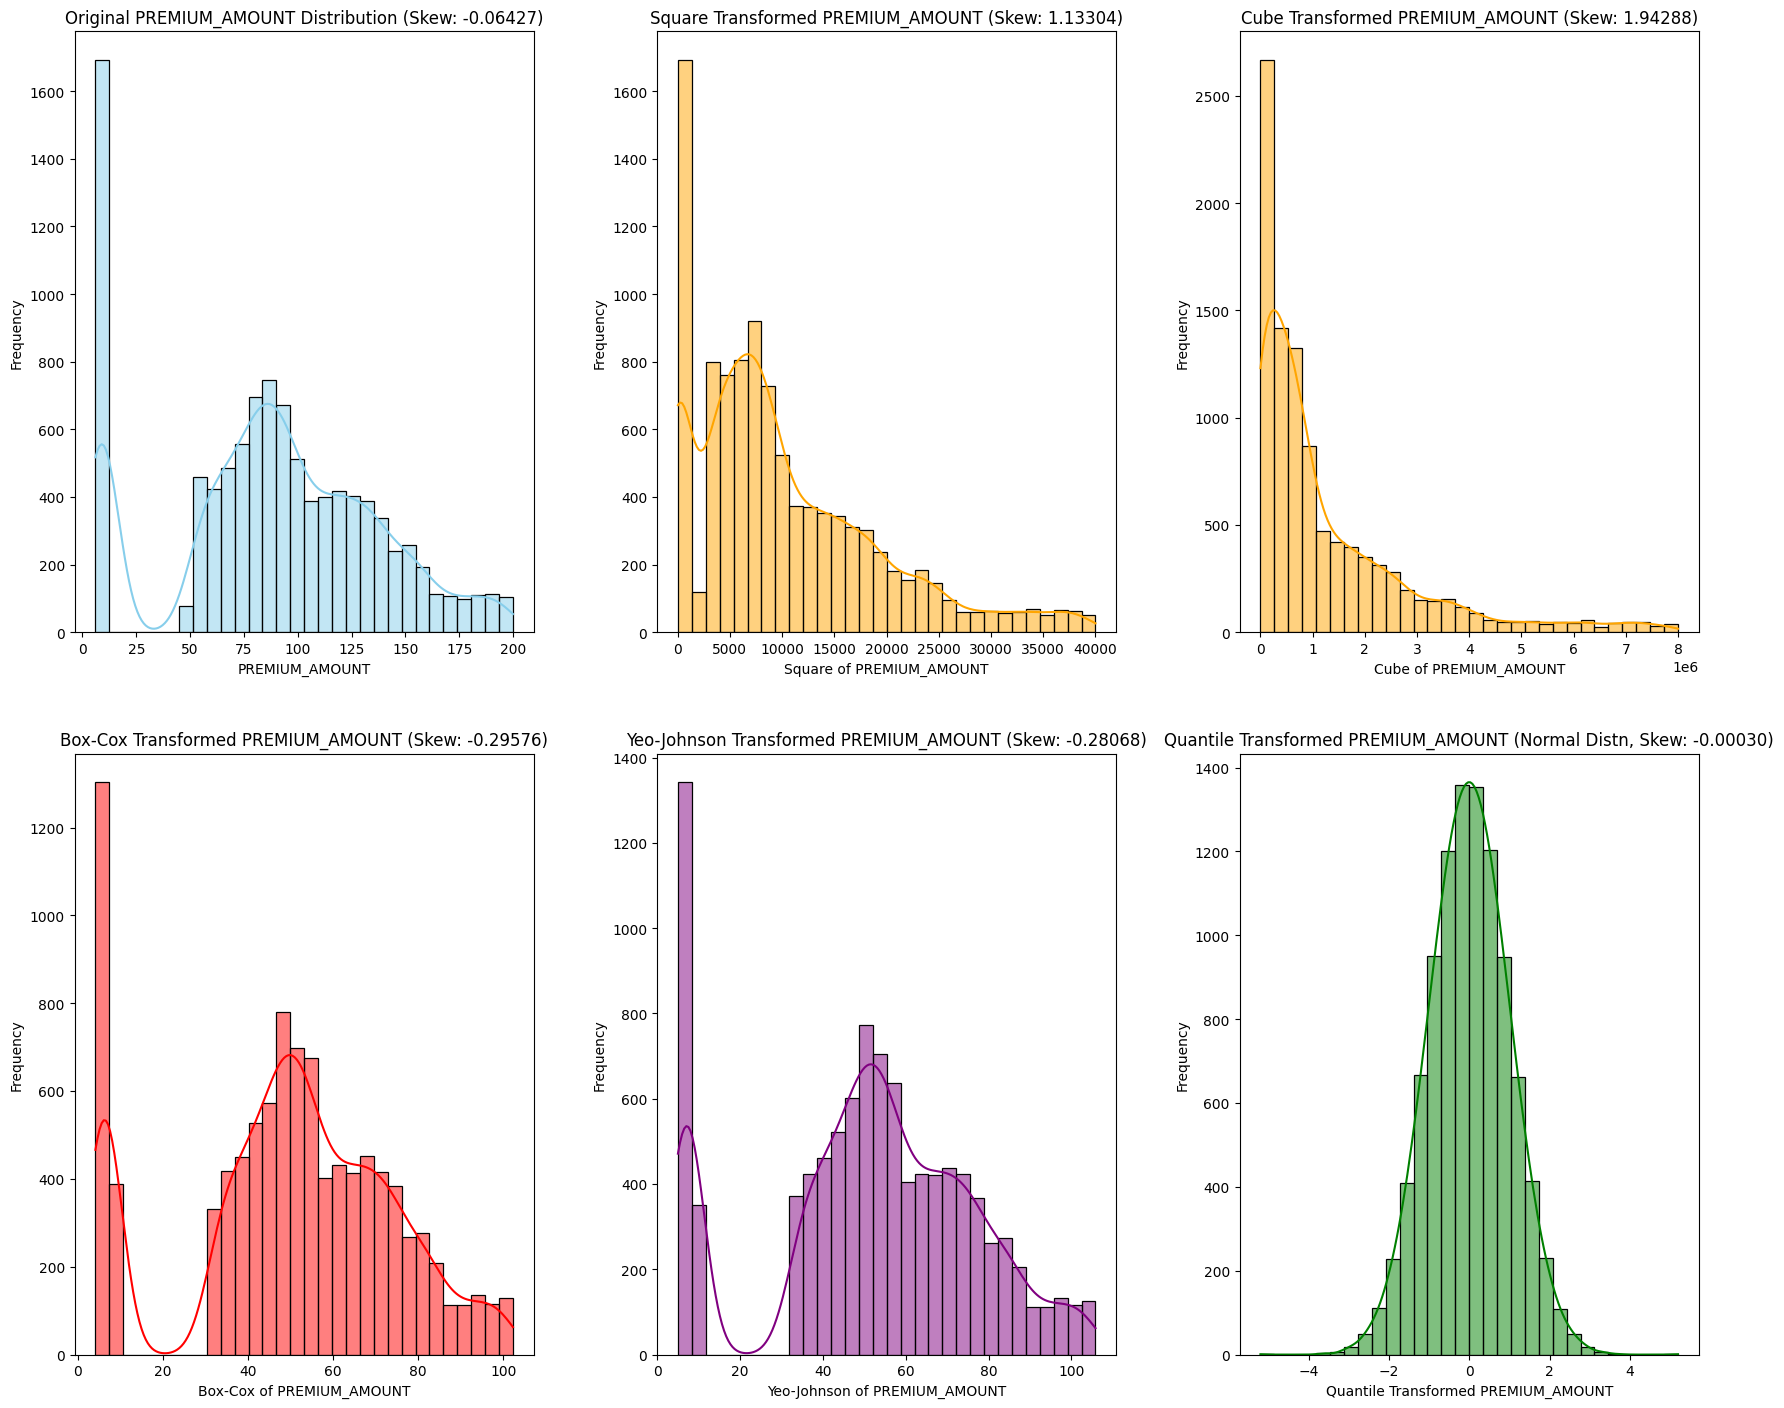

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 15)) 
axes = axes.flatten()

for ax in axes[6:]:
    ax.axis('off')


sns.histplot(df['PREMIUM_AMOUNT'], kde=True, bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Original PREMIUM_AMOUNT Distribution (Skew: -0.06427)')
axes[0].set_xlabel('PREMIUM_AMOUNT')
axes[0].set_ylabel('Frequency')


sns.histplot(df['Squared_PREMIUM_AMOUNT'], kde=True, bins=30, color='orange', ax=axes[1])
axes[1].set_title('Square Transformed PREMIUM_AMOUNT (Skew: 1.13304)')
axes[1].set_xlabel('Square of PREMIUM_AMOUNT')
axes[1].set_ylabel('Frequency')


sns.histplot(df['Cubed_PREMIUM_AMOUNT'], kde=True, bins=30, color='orange', ax=axes[2])
axes[2].set_title('Cube Transformed PREMIUM_AMOUNT (Skew: 1.94288)')
axes[2].set_xlabel('Cube of PREMIUM_AMOUNT')
axes[2].set_ylabel('Frequency')


sns.histplot(df['BoxCox_PREMIUM_AMOUNT'], kde=True, bins=30, color='red', ax=axes[3])
axes[3].set_title('Box-Cox Transformed PREMIUM_AMOUNT (Skew: -0.29576)')
axes[3].set_xlabel('Box-Cox of PREMIUM_AMOUNT')
axes[3].set_ylabel('Frequency')


sns.histplot(df['YeoJohnson_PREMIUM_AMOUNT'], kde=True, bins=30, color='purple', ax=axes[4])
axes[4].set_title('Yeo-Johnson Transformed PREMIUM_AMOUNT (Skew: -0.28068)')
axes[4].set_xlabel('Yeo-Johnson of PREMIUM_AMOUNT')
axes[4].set_ylabel('Frequency')


sns.histplot(df['Quantile_PREMIUM_AMOUNT'], kde=True, bins=30, color='green', ax=axes[5])
axes[5].set_title('Quantile Transformed PREMIUM_AMOUNT (Normal Distn, Skew: -0.00030)')
axes[5].set_xlabel('Quantile Transformed PREMIUM_AMOUNT')
axes[5].set_ylabel('Frequency')

plt.tight_layout(pad=4.0)
plt.show()

Null and Alternate Hypothesis:\
Null Hypothesis (H0): The data follows the specified distribution (normal distribution, in this case).\
Alternate Hypothesis (H1): The data does not follow the specified distribution.

In [16]:
from scipy.stats import kstest

transformations = ["Squared_PREMIUM_AMOUNT", "Cubed_PREMIUM_AMOUNT", "BoxCox_PREMIUM_AMOUNT",
                    "YeoJohnson_PREMIUM_AMOUNT", "Quantile_PREMIUM_AMOUNT"]

ks_test_results = {}
for transformation in transformations:
    standardized_data = (df[transformation] - df[transformation].mean()) / df[transformation].std()
    ks_stat, ks_p_value = kstest(standardized_data, 'norm')
    ks_test_results[transformation] = (ks_stat, ks_p_value)

ks_test_results_df = pd.DataFrame.from_dict(ks_test_results, orient='index', columns=['KS Statistic', 'P-Value'])
print(ks_test_results_df.round(5))

                           KS Statistic  P-Value
Squared_PREMIUM_AMOUNT          0.12672      0.0
Cubed_PREMIUM_AMOUNT            0.20621      0.0
BoxCox_PREMIUM_AMOUNT           0.11974      0.0
YeoJohnson_PREMIUM_AMOUNT       0.11936      0.0
Quantile_PREMIUM_AMOUNT         0.00139      1.0


Thus, for "Quantile_PREMIUM_AMOUNT" we fail to reject the null hypothesis

# Claim Amount

In [17]:
print(f"Original skewness: {df['CLAIM_AMOUNT'].skew()}")

df['Log_CLAIM_AMOUNT'] = np.log(df['CLAIM_AMOUNT'])
print(f"Skewness after Log Transformation: {df['Log_CLAIM_AMOUNT'].skew():.5f}")

df['Sqrt_CLAIM_AMOUNT'] = np.sqrt(df['CLAIM_AMOUNT'])
print(f"Skewness after Square Root Transformation: {df['Sqrt_CLAIM_AMOUNT'].skew():.5f}")

if (df['CLAIM_AMOUNT'] > 0).all():
    df['BoxCox_CLAIM_AMOUNT'], _ = boxcox(df['CLAIM_AMOUNT'])
else:
    print("Not all SalePrice values are positive. Consider using Yeo-Johnson or handling negative values.")
print(f"Skewness after Box-Cox Transformation: {df['BoxCox_CLAIM_AMOUNT'].skew():.5f}")

df['YeoJohnson_CLAIM_AMOUNT'], _ = yeojohnson(df['CLAIM_AMOUNT'])
print(f"Skewness after Yeo-Johnson Transformation: {df['YeoJohnson_CLAIM_AMOUNT'].skew():.5f}")

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df['Quantile_CLAIM_AMOUNT'] = quantile_transformer.fit_transform(df['CLAIM_AMOUNT'].values.reshape(-1, 1)).flatten()
print(f"Skewness after Quantile Transformation: {df['Quantile_CLAIM_AMOUNT'].skew():.5f}")

Original skewness: 1.9521848025361013
Skewness after Log Transformation: -0.45138
Skewness after Square Root Transformation: 0.91778
Skewness after Box-Cox Transformation: -0.06526
Skewness after Yeo-Johnson Transformation: -0.06511
Skewness after Quantile Transformation: -1.31866


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

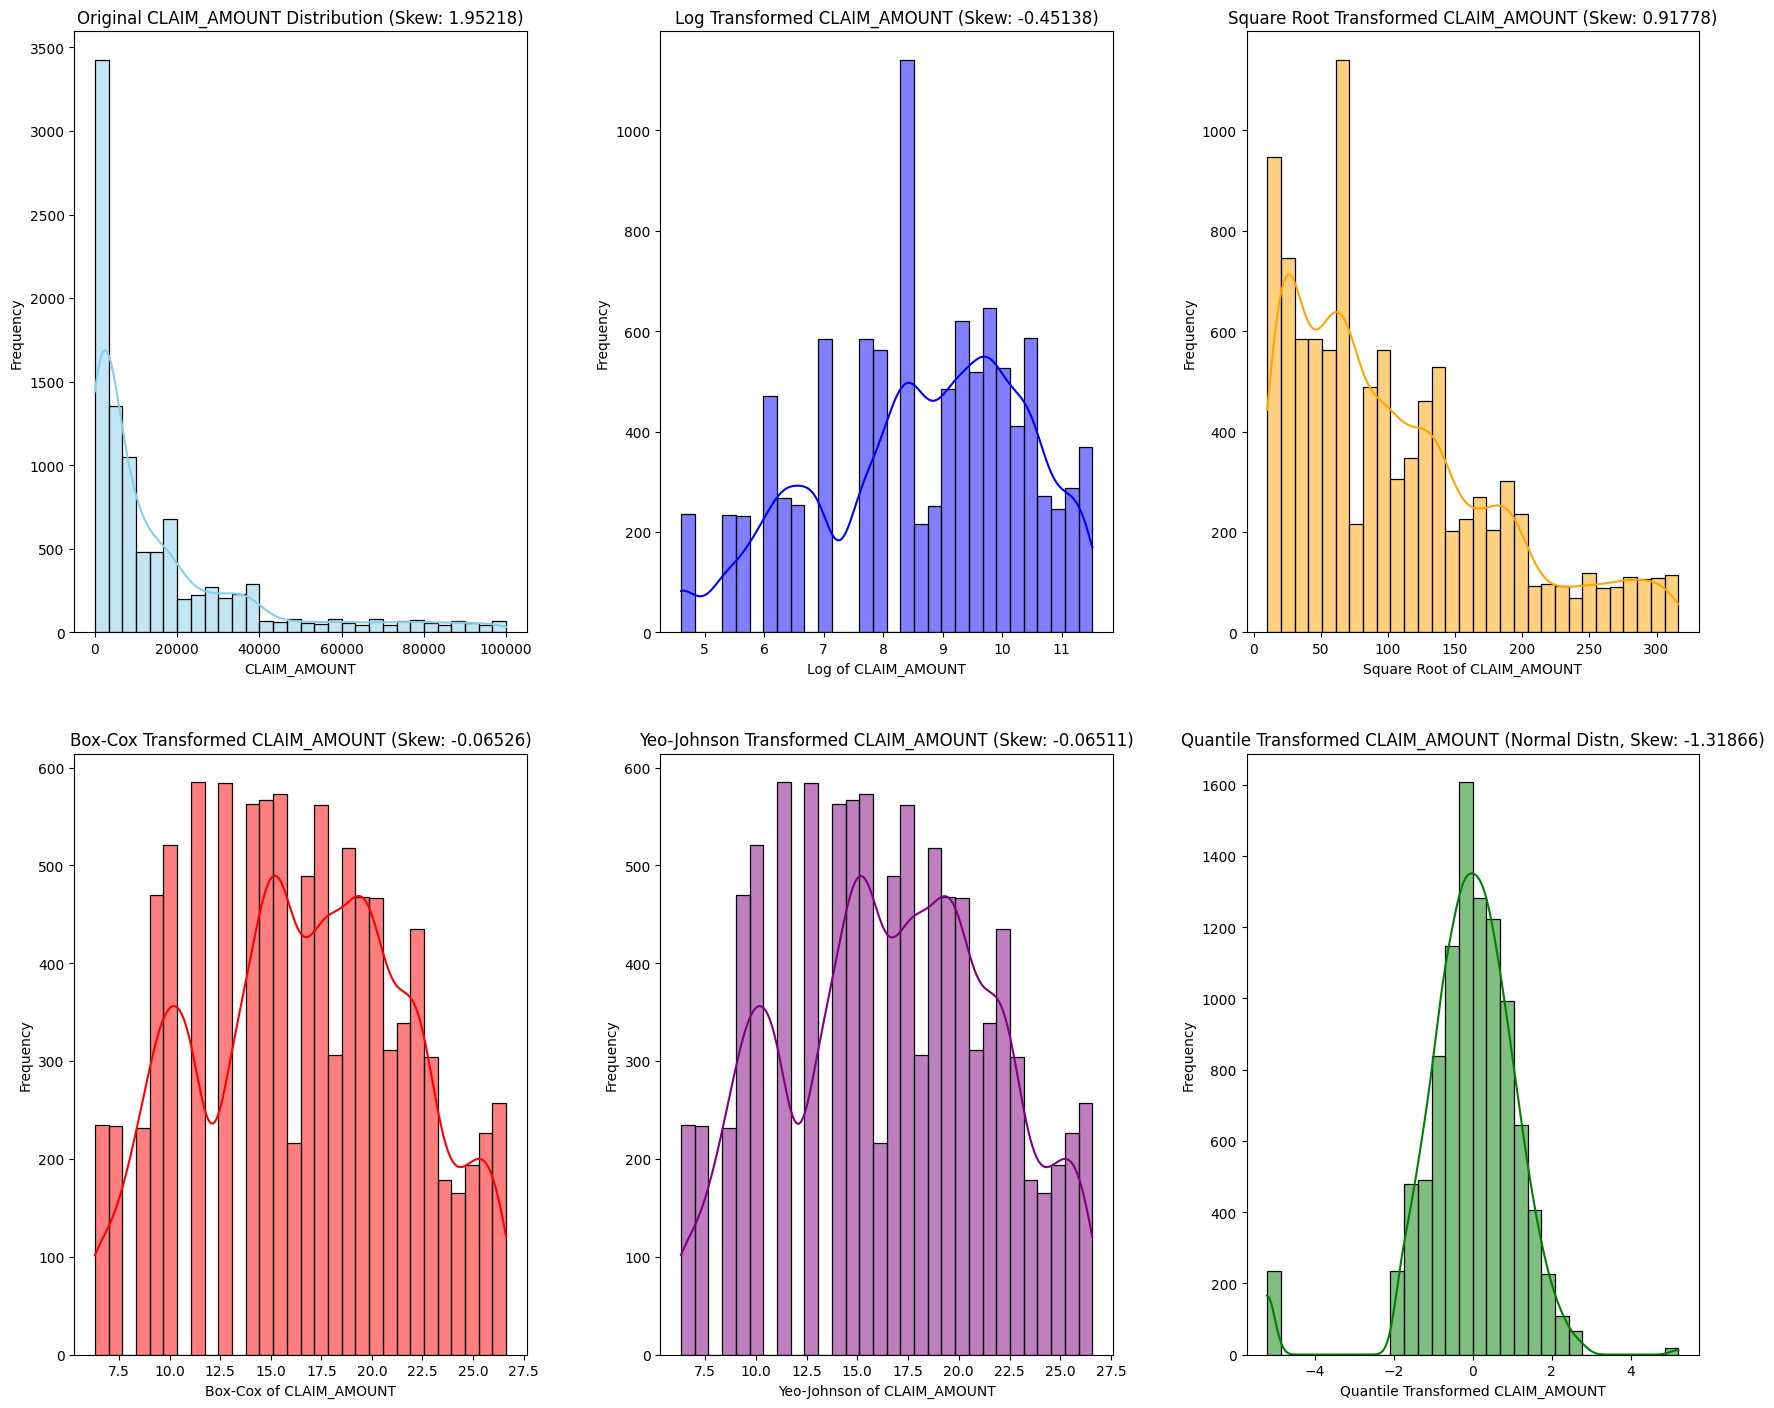

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 15))
axes = axes.flatten()
for ax in axes[6:]:
    ax.axis('off')


sns.histplot(df['CLAIM_AMOUNT'], kde=True, bins=30, color='skyblue', ax=axes[0])
axes[0].set_title('Original CLAIM_AMOUNT Distribution (Skew: 1.95218)')
axes[0].set_xlabel('CLAIM_AMOUNT')
axes[0].set_ylabel('Frequency')


sns.histplot(df['Log_CLAIM_AMOUNT'], kde=True, bins=30, color='blue', ax=axes[1])
axes[1].set_title('Log Transformed CLAIM_AMOUNT (Skew: -0.45138)')
axes[1].set_xlabel('Log of CLAIM_AMOUNT')
axes[1].set_ylabel('Frequency')


sns.histplot(df['Sqrt_CLAIM_AMOUNT'], kde=True, bins=30, color='orange', ax=axes[2])
axes[2].set_title('Square Root Transformed CLAIM_AMOUNT (Skew: 0.91778)')
axes[2].set_xlabel('Square Root of CLAIM_AMOUNT')
axes[2].set_ylabel('Frequency')


sns.histplot(df['BoxCox_CLAIM_AMOUNT'], kde=True, bins=30, color='red', ax=axes[3])
axes[3].set_title('Box-Cox Transformed CLAIM_AMOUNT (Skew: -0.06526)')
axes[3].set_xlabel('Box-Cox of CLAIM_AMOUNT')
axes[3].set_ylabel('Frequency')


sns.histplot(df['YeoJohnson_CLAIM_AMOUNT'], kde=True, bins=30, color='purple', ax=axes[4])
axes[4].set_title('Yeo-Johnson Transformed CLAIM_AMOUNT (Skew: -0.06511)')
axes[4].set_xlabel('Yeo-Johnson of CLAIM_AMOUNT')
axes[4].set_ylabel('Frequency')


sns.histplot(df['Quantile_CLAIM_AMOUNT'], kde=True, bins=30, color='green', ax=axes[5])
axes[5].set_title('Quantile Transformed CLAIM_AMOUNT (Normal Distn, Skew: -1.31866)')
axes[5].set_xlabel('Quantile Transformed CLAIM_AMOUNT')
axes[5].set_ylabel('Frequency')

plt.tight_layout(pad=4.0)
plt.show()

In [19]:
# Null and Alternate Hypothesis:\
# Null Hypothesis (H0): The data follows the specified distribution (normal distribution, in this case).\
# Alternate Hypothesis (H1): The data does not follow the specified distribution.

from scipy.stats import kstest


transformations = ["Log_CLAIM_AMOUNT", "Sqrt_CLAIM_AMOUNT", "BoxCox_CLAIM_AMOUNT",
                    "YeoJohnson_CLAIM_AMOUNT", "Quantile_CLAIM_AMOUNT"]


ks_test_results = {}
for transformation in transformations:
    standardized_data = (df[transformation] - df[transformation].mean()) / df[transformation].std()
    ks_stat, ks_p_value = kstest(standardized_data, 'norm')
    ks_test_results[transformation] = (ks_stat, ks_p_value)


ks_test_results_df = pd.DataFrame.from_dict(ks_test_results, orient='index', columns=['KS Statistic', 'P-Value'])
print(ks_test_results_df.round(5))

                         KS Statistic  P-Value
Log_CLAIM_AMOUNT              0.07518      0.0
Sqrt_CLAIM_AMOUNT             0.12579      0.0
BoxCox_CLAIM_AMOUNT           0.08066      0.0
YeoJohnson_CLAIM_AMOUNT       0.08073      0.0
Quantile_CLAIM_AMOUNT         0.09378      0.0


There is enough evidence to reject the Null Hypothesis